# 02: Tag Analysis

This notebook analyzes tag co-occurrence patterns and clusters semantically related tags using NPMI-weighted graphs and Leiden community detection. The output is a set of cluster labels mapping fine-grained tags to interpretable groups.

## Setup

In [37]:
import sys
from pathlib import Path
from collections import Counter
from itertools import combinations
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# force fresh import to avoid stale module caching
import core.space.annotate
importlib.reload(core.space.annotate)

from core.space.annotate import (
    build_top_k_dataframe,
    build_tag_graph,
    prune_graph_topk,
    cluster_tags,
    merge_clusters,
    write_cluster_labels,
    compute_npmi,
)

In [38]:
# verify API accepts expected parameters
import inspect
sig = inspect.signature(build_tag_graph)
assert "min_cooccurrence" in sig.parameters, "API mismatch: min_cooccurrence not found"
assert "min_tag_count" in sig.parameters, "API mismatch: min_tag_count not found"
print(f"build_tag_graph signature: {sig}")

build_tag_graph signature: (df: pandas.core.frame.DataFrame, tag_col: str, min_cooccurrence: int = 2, min_tag_count: int = 3) -> Any


In [39]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 10

## Load Data

In [40]:
df = pd.read_csv(project_root / "notebooks" / "data" / "merge_preprocessed.csv")
print(f"Loaded {len(df)} tracks")

Loaded 2487 tracks


In [41]:
df = build_top_k_dataframe(df)
print(f"Added columns: {[c for c in df.columns if c.startswith('top_k')]}")

Added columns: ['top_k_genre', 'top_k_theme', 'top_k_mood', 'top_k_style']


In [42]:
from dataset.filter import consolidate_genres, GENRE_TAXONOMY

# build case-insensitive lookup from taxonomy
_genre_case_map = {}
for consolidated, originals in GENRE_TAXONOMY.items():
    for orig in originals:
        _genre_case_map[orig.lower()] = orig

def consolidate_genres_ci(genres: tuple[str, ...]) -> tuple[str, ...]:
    """Case-insensitive wrapper for consolidate_genres."""
    # restore original case before consolidation
    restored = tuple(_genre_case_map.get(g.lower(), g) for g in genres)
    return consolidate_genres(restored)

df["top_k_genre_consolidated"] = df["top_k_genre"].apply(consolidate_genres_ci)

In [43]:
# parse raw theme column into tuples for unweighted clustering
def parse_tags(s: str | float) -> tuple[str, ...]:
    """Parse comma-separated tag string into tuple."""
    if pd.isna(s):
        return ()
    return tuple(t.strip().lower() for t in str(s).split(",") if t.strip())

df["theme_tags"] = df["theme"].apply(parse_tags)
print(f"theme_tags: {df['theme_tags'].apply(len).sum()} total tags across {len(df)} tracks")

theme_tags: 11554 total tags across 2487 tracks


## Tag Vocabulary

Count unique tags per category and visualize frequency distributions.

In [44]:
def count_unique_tags(series: pd.Series) -> tuple[int, Counter]:
    """Count unique tags and their frequencies."""
    counts = Counter()
    for tags in series:
        for t in tags:
            counts[t] += 1
    return len(counts), counts

for col in ["top_k_genre", "top_k_theme", "top_k_mood", "top_k_style"]:
    n_unique, _ = count_unique_tags(df[col])
    print(f"{col}: {n_unique} unique tags")

top_k_genre: 21 unique tags
top_k_theme: 154 unique tags
top_k_mood: 211 unique tags
top_k_style: 473 unique tags


### Genre distribution (consolidated)

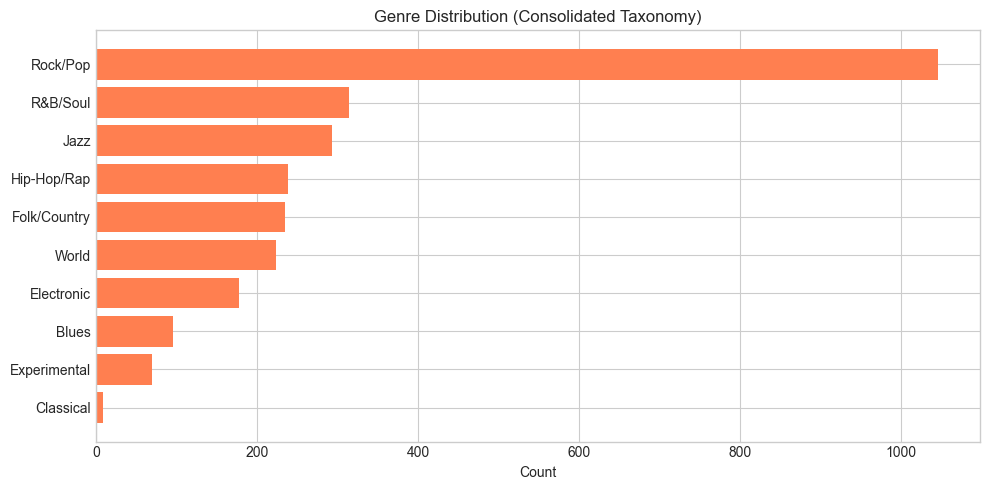

In [45]:
_, genre_counts = count_unique_tags(df["top_k_genre_consolidated"])
top_genres = genre_counts.most_common(10)

fig, ax = plt.subplots(figsize=(10, 5))
tags, counts = zip(*top_genres)
ax.barh(range(len(tags)), counts, color="coral")
ax.set_yticks(range(len(tags)))
ax.set_yticklabels(tags)
ax.invert_yaxis()
ax.set_xlabel("Count")
ax.set_title("Genre Distribution (Consolidated Taxonomy)")
plt.tight_layout()
plt.show()

In [46]:
print(f"Consolidated genres: {len(genre_counts)} categories\n")
for genre, count in top_genres:
    pct = 100 * count / sum(counts)
    print(f"{genre:15} {count:5} ({pct:5.1f}%)")

Consolidated genres: 10 categories

Rock/Pop         1046 ( 38.7%)
R&B/Soul          314 ( 11.6%)
Jazz              293 ( 10.8%)
Hip-Hop/Rap       239 (  8.8%)
Folk/Country      235 (  8.7%)
World             224 (  8.3%)
Electronic        178 (  6.6%)
Blues              96 (  3.6%)
Experimental       69 (  2.6%)
Classical           9 (  0.3%)


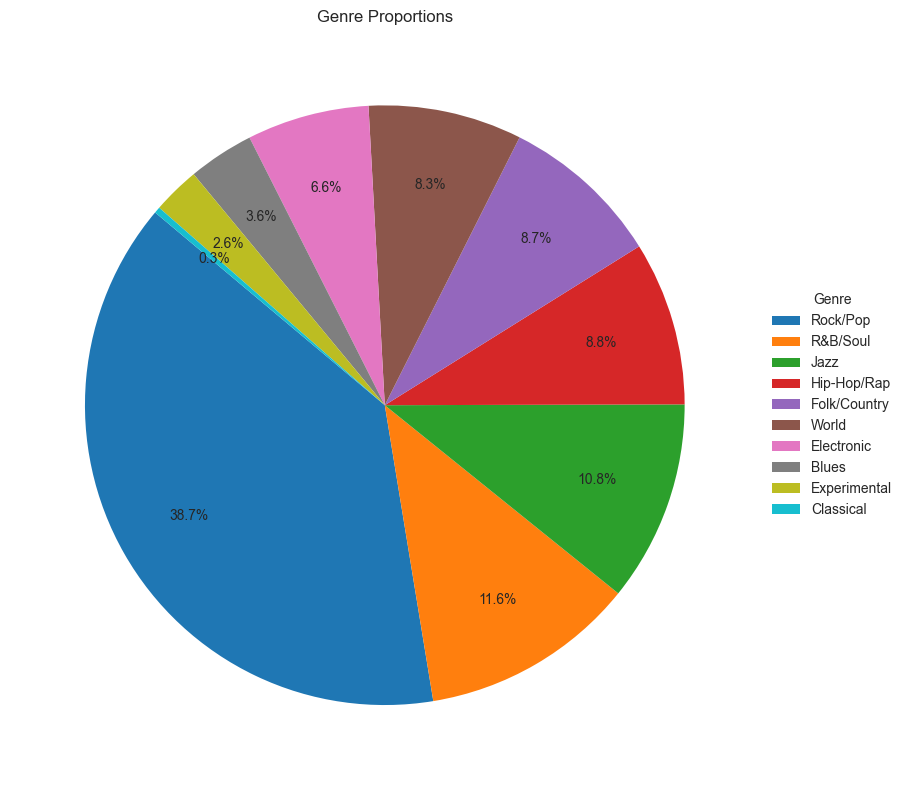

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(
    counts,
    autopct="%1.1f%%",
    startangle=140,
    pctdistance=0.75,
)
ax.legend(wedges, tags, title="Genre", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Genre Proportions")
plt.tight_layout()
plt.show()

### Theme tag distribution

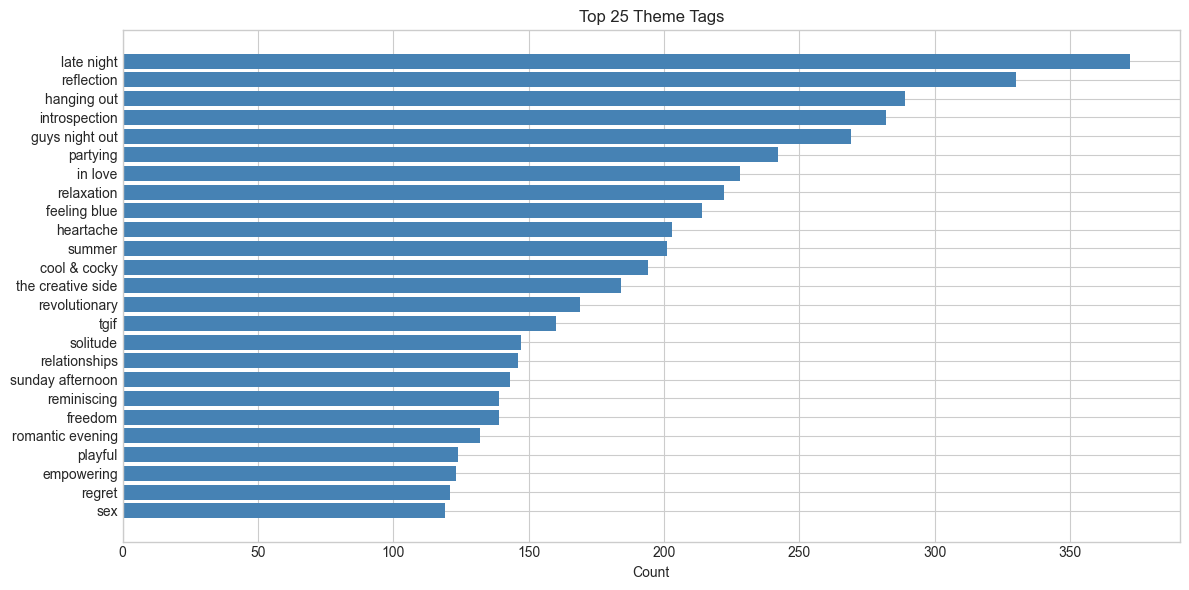

In [48]:
_, theme_counts = count_unique_tags(df["top_k_theme"])
top_themes = theme_counts.most_common(25)

fig, ax = plt.subplots(figsize=(12, 6))
tags, counts = zip(*top_themes)
ax.barh(range(len(tags)), counts, color="steelblue")
ax.set_yticks(range(len(tags)))
ax.set_yticklabels(tags)
ax.invert_yaxis()
ax.set_xlabel("Count")
ax.set_title("Top 25 Theme Tags")
plt.tight_layout()
plt.show()

## Co-occurrence Analysis

Analyze how tags appear together across songs.

### Co-occurrence matrix

In [49]:
def build_cooccurrence_matrix(series: pd.Series, top_n: int = 30) -> pd.DataFrame:
    """Build tag co-occurrence matrix for top N tags."""
    counts = Counter()
    for tags in series:
        for t in tags:
            counts[t] += 1
    
    top_tags = [t for t, _ in counts.most_common(top_n)]
    tag_set = set(top_tags)
    
    cooc = Counter()
    for tags in series:
        filtered = [t for t in tags if t in tag_set]
        for i, j in combinations(sorted(set(filtered)), 2):
            cooc[(i, j)] += 1
            cooc[(j, i)] += 1
    
    matrix = pd.DataFrame(0, index=top_tags, columns=top_tags)
    for (i, j), count in cooc.items():
        matrix.loc[i, j] = count
    
    # diagonal = self count
    for t in top_tags:
        matrix.loc[t, t] = counts[t]
    
    return matrix

cooc_matrix = build_cooccurrence_matrix(df["top_k_theme"], top_n=30)
cooc_matrix.shape

(30, 30)

### Heatmap

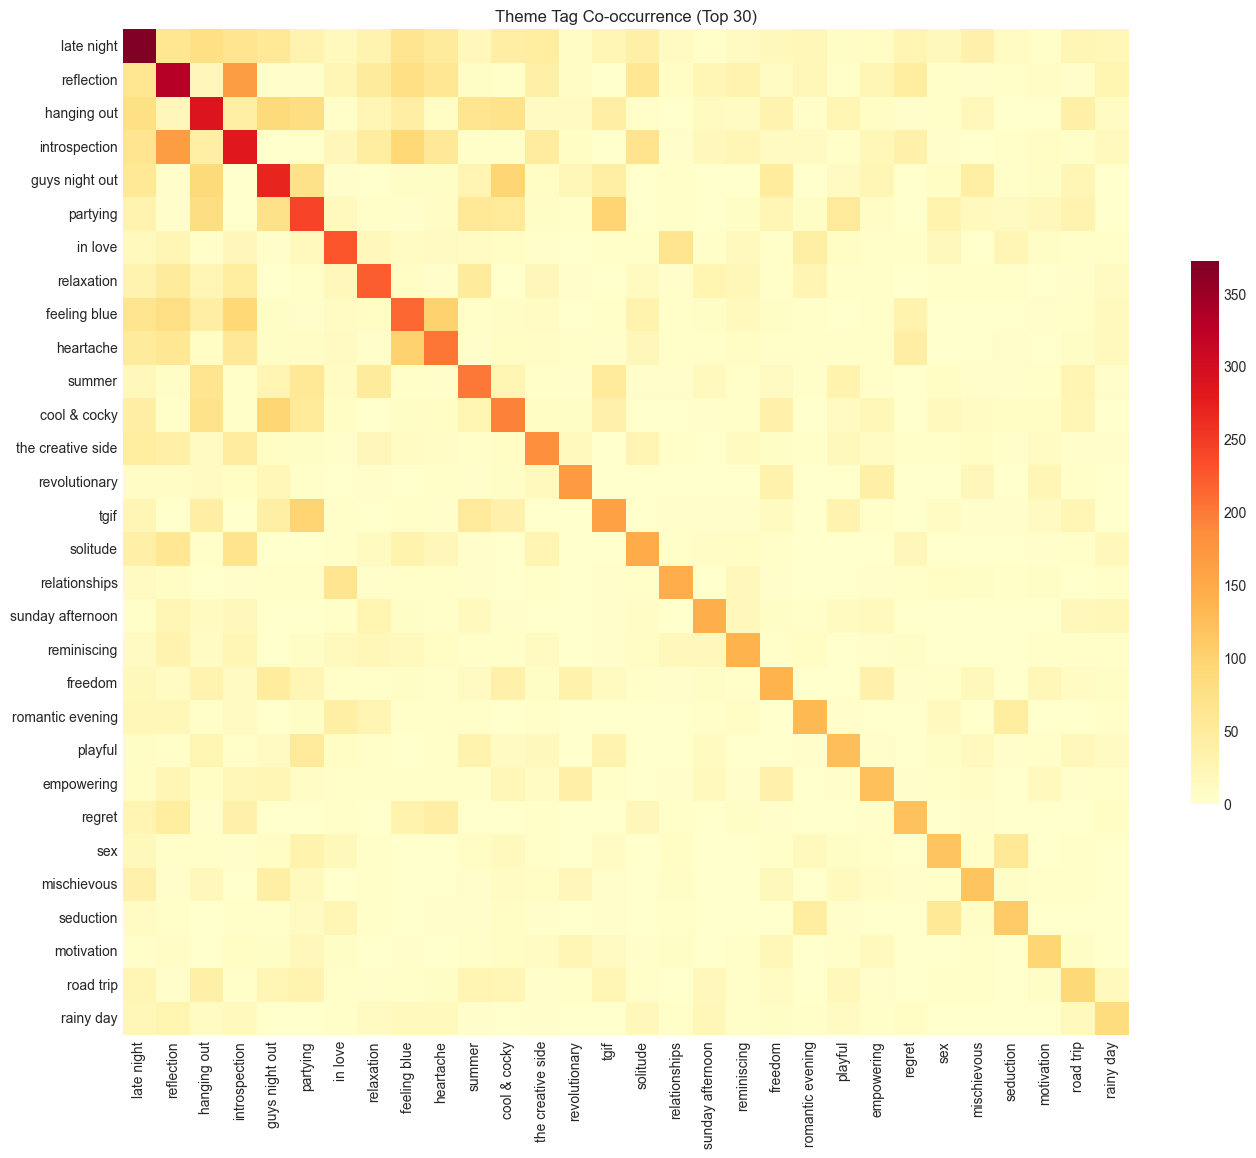

In [50]:
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    cooc_matrix,
    cmap="YlOrRd",
    ax=ax,
    square=True,
    cbar_kws={"shrink": 0.5},
)
ax.set_title("Theme Tag Co-occurrence (Top 30)")
plt.tight_layout()
plt.show()

### NPMI Table

Normalized Pointwise Mutual Information measures association strength beyond raw counts.

In [51]:
def build_npmi_table(series: pd.Series, min_count: int = 3) -> pd.DataFrame:
    """Build table of tag pairs with co-occurrence counts and NPMI."""
    n_total = len(series)
    
    tag_counts = Counter()
    for tags in series:
        for t in tags:
            tag_counts[t] += 1
    
    # filter by min count
    valid = {t for t, c in tag_counts.items() if c >= min_count}
    
    pair_counts = Counter()
    for tags in series:
        filtered = [t for t in tags if t in valid]
        for i, j in combinations(sorted(set(filtered)), 2):
            pair_counts[(i, j)] += 1
    
    rows = []
    for (t_a, t_b), n_pairs in pair_counts.items():
        if n_pairs < 2:
            continue
        npmi = compute_npmi(tag_counts[t_a], tag_counts[t_b], n_pairs, n_total)
        rows.append({
            "tag_a": t_a,
            "tag_b": t_b,
            "n_pairs": n_pairs,
            "npmi": npmi,
        })
    
    return pd.DataFrame(rows).sort_values("npmi", ascending=False)

npmi_df = build_npmi_table(df["top_k_theme"])
print(f"Total pairs: {len(npmi_df)}")
npmi_df.head(20)

Total pairs: 1704


,tag_a,tag_b,n_pairs,npmi
231,christmas party,holidays,37,0.905210
531,animals,country life,2,0.774136
230,christmas party,family gatherings,20,0.758838
989,fear,sorrow,2,0.742820
862,death,historical events,4,0.742212
603,protest,war,2,0.732020
1358,dreaming,money,2,0.726916
598,death,war,3,0.710440
750,christmas,religion,2,0.703858
6,country life,travel,2,0.695601


### Network Visualization

In [52]:
def build_networkx_graph(npmi_df: pd.DataFrame, min_npmi: float = 0.1) -> nx.Graph:
    """Build NetworkX graph from NPMI table."""
    g = nx.Graph()
    for _, row in npmi_df.iterrows():
        if row["npmi"] >= min_npmi:
            g.add_edge(row["tag_a"], row["tag_b"], weight=row["npmi"])
    return g

nx_graph = build_networkx_graph(npmi_df, min_npmi=0.15)
print(f"Nodes: {nx_graph.number_of_nodes()}, Edges: {nx_graph.number_of_edges()}")

Nodes: 138, Edges: 949


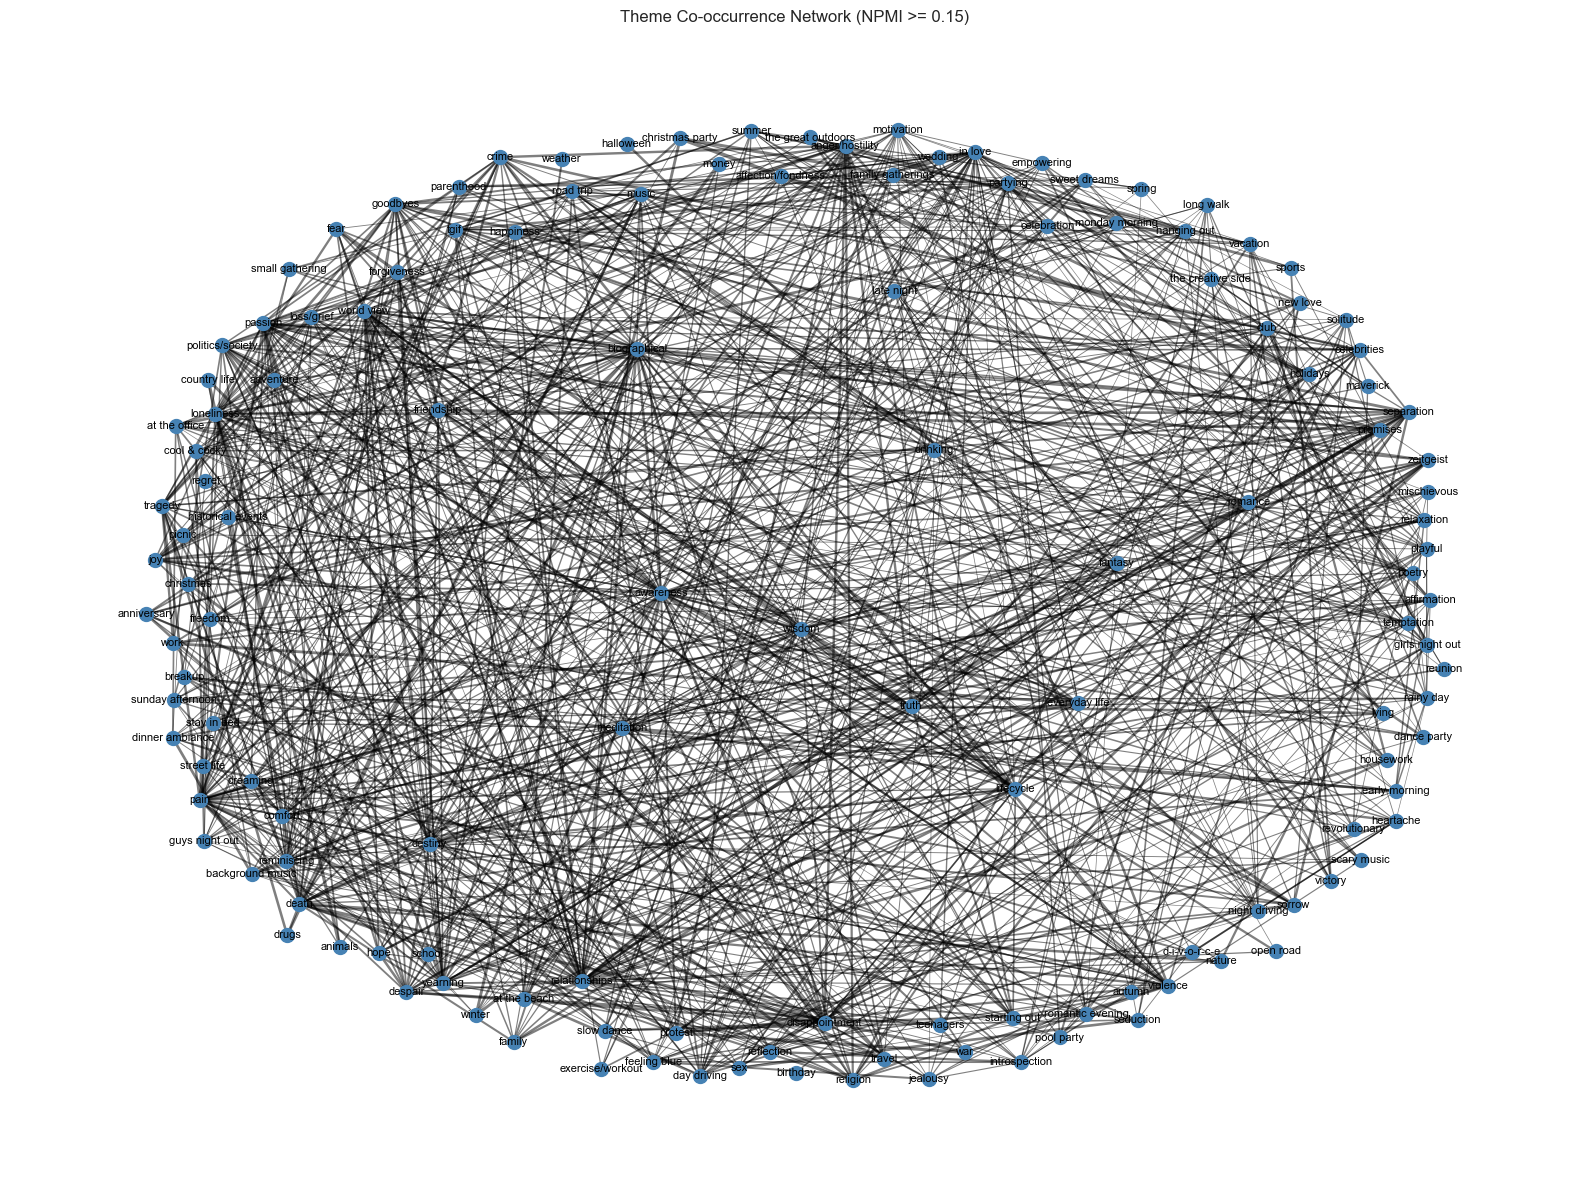

In [53]:
fig, ax = plt.subplots(figsize=(16, 12))

pos = nx.spring_layout(nx_graph, seed=42, k=2)
weights = [nx_graph[u][v]["weight"] * 3 for u, v in nx_graph.edges()]

nx.draw_networkx_nodes(nx_graph, pos, node_size=100, node_color="steelblue", ax=ax)
nx.draw_networkx_edges(nx_graph, pos, width=weights, alpha=0.5, ax=ax)
nx.draw_networkx_labels(nx_graph, pos, font_size=8, ax=ax)

ax.set_title("Theme Co-occurrence Network (NPMI >= 0.15)")
ax.axis("off")
plt.tight_layout()
plt.show()

## Graph Metrics

In [54]:
print(f"Nodes: {nx_graph.number_of_nodes()}")
print(f"Edges: {nx_graph.number_of_edges()}")
print(f"Density: {nx.density(nx_graph):.4f}")
print(f"Avg clustering coefficient: {nx.average_clustering(nx_graph):.4f}")
print(f"Connected components: {nx.number_connected_components(nx_graph)}")

Nodes: 138
Edges: 949
Density: 0.1004
Avg clustering coefficient: 0.4982
Connected components: 1


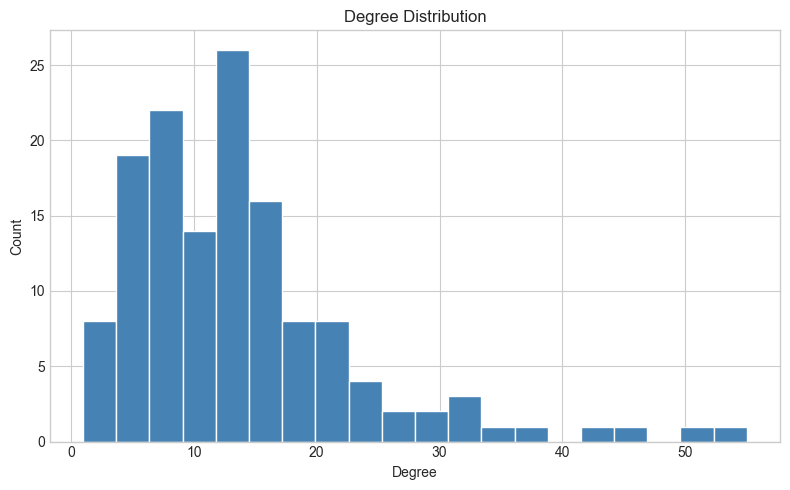

In [55]:
degrees = [d for _, d in nx_graph.degree()]

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(degrees, bins=20, color="steelblue", edgecolor="white")
ax.set_xlabel("Degree")
ax.set_ylabel("Count")
ax.set_title("Degree Distribution")
plt.tight_layout()
plt.show()

## Clustering

Cluster tags using Leiden community detection on the NPMI-weighted graph.

### Leiden community detection

In [56]:
ig_graph = build_tag_graph(df, "top_k_theme", min_cooccurrence=2, min_tag_count=5)

print(f"Nodes: {ig_graph.vcount()}, Edges: {ig_graph.ecount()}")

Nodes: 127, Edges: 1276


In [57]:
result = cluster_tags(ig_graph, resolution=1.0, seed=42, prefix="T")

print(f"Clusters: {result.n_clusters}")
print(f"Tags: {result.n_tags}")
print(f"Modularity: {result.modularity:.4f}")

Clusters: 6
Tags: 127
Modularity: 0.3832


In [58]:
cluster_sizes = [(cid, len(tags)) for cid, tags in result.clusters.items()]
cluster_sizes = sorted(cluster_sizes, key=lambda x: -x[1])

print("Cluster sizes:")
for cid, size in cluster_sizes[:10]:
    print(f"  {cid}: {size} tags")

Cluster sizes:
  T1: 50 tags
  T2: 37 tags
  T3: 27 tags
  T4: 9 tags
  T5: 3 tags
  T6: 1 tags


### Community visualization

/var/folders/xj/q2hvgrs103gcrg_vkzc7m6vm0000gn/T/ipykernel_81934/2262983316.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", result.n_clusters)


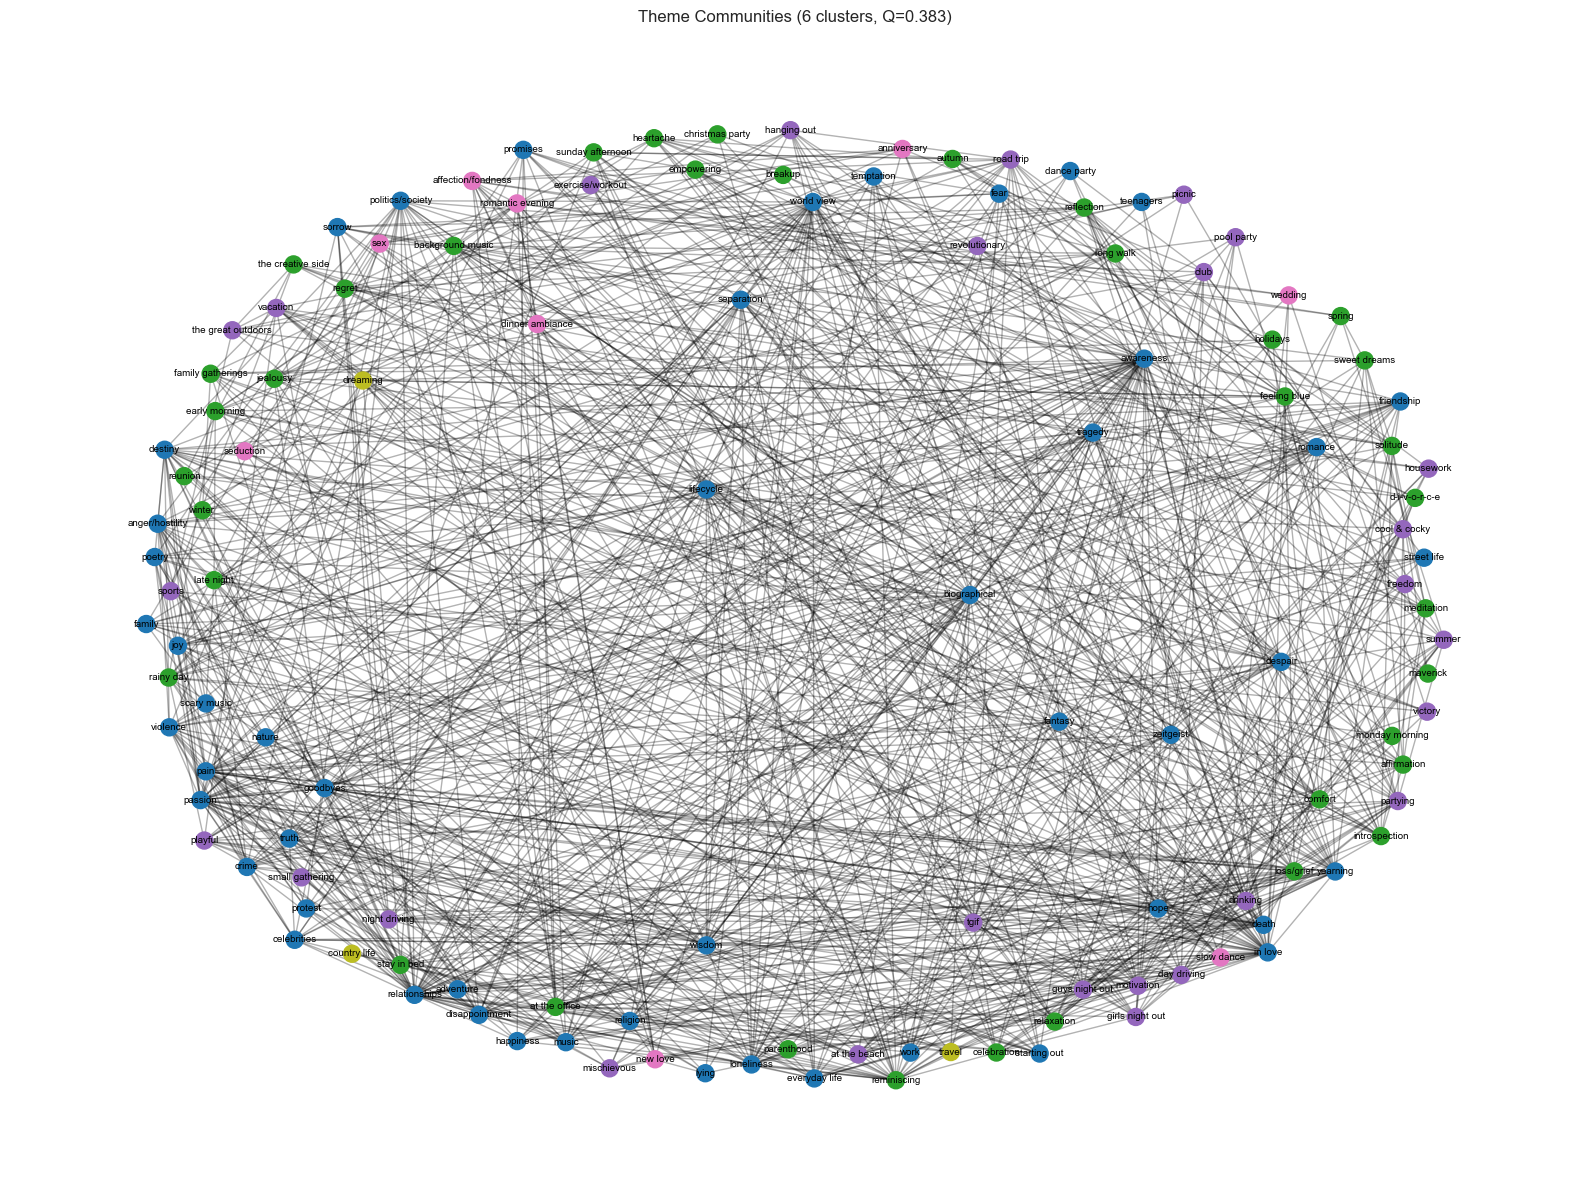

In [59]:
# build networkx graph with cluster colors
cluster_colors = {}
cmap = plt.cm.get_cmap("tab20", result.n_clusters)
for i, cid in enumerate(result.clusters.keys()):
    cluster_colors[cid] = cmap(i)

# filter to nodes in both graphs
ig_names = set(ig_graph.vs["name"])
subgraph = nx_graph.subgraph([n for n in nx_graph.nodes() if n in ig_names])

node_colors = [cluster_colors.get(result.tag_to_cluster.get(n, "T1"), "gray") for n in subgraph.nodes()]

fig, ax = plt.subplots(figsize=(16, 12))
pos = nx.spring_layout(subgraph, seed=42, k=2)

nx.draw_networkx_nodes(subgraph, pos, node_size=150, node_color=node_colors, ax=ax)
nx.draw_networkx_edges(subgraph, pos, alpha=0.3, ax=ax)
nx.draw_networkx_labels(subgraph, pos, font_size=7, ax=ax)

ax.set_title(f"Theme Communities ({result.n_clusters} clusters, Q={result.modularity:.3f})")
ax.axis("off")
plt.tight_layout()
plt.show()

### Annotation labels

In [60]:
for cid, tags in list(result.clusters.items())[:]:
    print(f"{cid}: {', '.join(tags[:])}{'...' if len(tags) > 8 else ''}")

T1: adventure, anger/hostility, awareness, biographical, celebrities, crime, dance party, death, despair, destiny, disappointment, everyday life, family, fantasy, fear, friendship, goodbyes, happiness, hope, in love, joy, lifecycle, loneliness, lying, music, nature, pain, passion, poetry, politics/society, promises, protest, relationships, religion, romance, scary music, separation, sorrow, starting out, street life, teenagers, temptation, tragedy, truth, violence, wisdom, work, world view, yearning, zeitgeist...
T2: affirmation, at the office, autumn, background music, breakup, celebration, christmas party, comfort, d-i-v-o-r-c-e, early morning, empowering, family gatherings, feeling blue, heartache, holidays, introspection, jealousy, late night, long walk, loss/grief, maverick, meditation, monday morning, parenthood, rainy day, reflection, regret, relaxation, reminiscing, reunion, solitude, spring, stay in bed, sunday afternoon, sweet dreams, the creative side, winter...
T3: at the b

In [61]:
# output as dict for inspection
labels_dict = {k: list(v) for k, v in result.clusters.items()}
labels_dict

{'T1': ['adventure',
  'anger/hostility',
  'awareness',
  'biographical',
  'celebrities',
  'crime',
  'dance party',
  'death',
  'despair',
  'destiny',
  'disappointment',
  'everyday life',
  'family',
  'fantasy',
  'fear',
  'friendship',
  'goodbyes',
  'happiness',
  'hope',
  'in love',
  'joy',
  'lifecycle',
  'loneliness',
  'lying',
  'music',
  'nature',
  'pain',
  'passion',
  'poetry',
  'politics/society',
  'promises',
  'protest',
  'relationships',
  'religion',
  'romance',
  'scary music',
  'separation',
  'sorrow',
  'starting out',
  'street life',
  'teenagers',
  'temptation',
  'tragedy',
  'truth',
  'violence',
  'wisdom',
  'work',
  'world view',
  'yearning',
  'zeitgeist'],
 'T2': ['affirmation',
  'at the office',
  'autumn',
  'background music',
  'breakup',
  'celebration',
  'christmas party',
  'comfort',
  'd-i-v-o-r-c-e',
  'early morning',
  'empowering',
  'family gatherings',
  'feeling blue',
  'heartache',
  'holidays',
  'introspection

## Graph Filtering

Sweep min_cooccurrence to find cleaner community structure.

In [62]:
def sweep_min_cooccurrence(df, tag_col: str, values: list[int]) -> pd.DataFrame:
    """Sweep min_cooccurrence, cluster at resolution=1.0, return stats."""
    rows = []
    for min_cooc in values:
        g = build_tag_graph(df, tag_col, min_cooccurrence=min_cooc, min_tag_count=5)
        r = cluster_tags(g, resolution=1.0, seed=42, prefix="T")
        sizes = sorted([len(t) for t in r.clusters.values()], reverse=True)
        rows.append({
            "min_cooc": min_cooc,
            "nodes": g.vcount(),
            "edges": g.ecount(),
            "n_clusters": r.n_clusters,
            "modularity": round(r.modularity, 3),
            "max": sizes[0],
            "sizes": sizes[:5],
        })
    return pd.DataFrame(rows)

In [63]:
sweep_min_cooccurrence(df, "top_k_theme", [2, 3, 5, 7, 10])

,min_cooc,nodes,edges,n_clusters,modularity,max,sizes
0,2,127,1276,6,0.383,50,"[50, 37, 27, 9, 3]"
1,3,127,933,7,0.426,52,"[52, 33, 25, 9, 6]"
2,5,127,603,25,0.466,35,"[35, 30, 29, 9, 4]"
3,7,127,448,33,0.447,34,"[34, 19, 15, 15, 13]"
4,10,127,319,55,0.443,20,"[20, 16, 13, 12, 10]"


In [64]:
CHOSEN_MIN_COOC = 7  # adjust based on sweep results

ig_graph = build_tag_graph(df, "top_k_theme", min_cooccurrence=CHOSEN_MIN_COOC, min_tag_count=5)
print(f"Nodes: {ig_graph.vcount()}, Edges: {ig_graph.ecount()}")

Nodes: 127, Edges: 448


In [65]:
result = cluster_tags(ig_graph, resolution=1.0, seed=42, prefix="T")
print(f"Clusters: {result.n_clusters}, Modularity: {result.modularity:.4f}")

Clusters: 33, Modularity: 0.4473


In [66]:
[(cid, len(tags)) for cid, tags in result.clusters.items()]

[('T1', 34),
 ('T2', 19),
 ('T3', 15),
 ('T4', 15),
 ('T5', 13),
 ('T6', 4),
 ('T7', 1),
 ('T8', 1),
 ('T9', 1),
 ('T10', 1),
 ('T11', 1),
 ('T12', 1),
 ('T13', 1),
 ('T14', 1),
 ('T15', 1),
 ('T16', 1),
 ('T17', 1),
 ('T18', 1),
 ('T19', 1),
 ('T20', 1),
 ('T21', 1),
 ('T22', 1),
 ('T23', 1),
 ('T24', 1),
 ('T25', 1),
 ('T26', 1),
 ('T27', 1),
 ('T28', 1),
 ('T29', 1),
 ('T30', 1),
 ('T31', 1),
 ('T32', 1),
 ('T33', 1)]

### Pruned Pipeline (Recommended)

Use soft graph filtering followed by top-k edge pruning to reduce hub effects before clustering.

In [67]:
# build graph with soft filter
ig_graph = build_tag_graph(df, "top_k_theme", min_cooccurrence=2, min_tag_count=5)
print(f"Full graph: {ig_graph.vcount()} nodes, {ig_graph.ecount()} edges")

# prune to bound hub degree
ig_pruned = prune_graph_topk(ig_graph, k=8)
print(f"Pruned: {ig_pruned.ecount()} edges (was {ig_graph.ecount()})")

# cluster
result = cluster_tags(ig_pruned, resolution=1.0, seed=42, prefix="T")
print(f"Initial: {result.n_clusters} clusters, Q={result.modularity:.3f}")

# merge to target
TARGET_K = 7
merged = merge_clusters(ig_pruned, result, target_k=TARGET_K, prefix="T")
print(f"Final: {merged.n_clusters} clusters")

for cid, tags in merged.clusters.items():
    print(f"  {cid} ({len(tags):2d}): {', '.join(tags[:])}{'...' if len(tags) > 6 else ''}")

Full graph: 127 nodes, 1276 edges
Pruned: 639 edges (was 1276)
Initial: 7 clusters, Q=0.517
Final: 7 clusters
  T1 (34): adventure, awareness, biographical, country life, dance party, despair, disappointment, dreaming, everyday life, fear, friendship, goodbyes, happiness, hope, joy, loneliness, loss/grief, music, nature, pain, passion, poetry, promises, relationships, reminiscing, romance, separation, sorrow, teenagers, temptation, tragedy, travel, work, yearning...
  T2 (31): at the beach, club, cool & cocky, day driving, drinking, empowering, exercise/workout, freedom, girls night out, guys night out, hanging out, housework, maverick, mischievous, motivation, night driving, partying, picnic, playful, pool party, reunion, revolutionary, road trip, small gathering, sports, summer, tgif, the creative side, the great outdoors, vacation, victory...
  T3 (20): anger/hostility, celebrities, crime, death, destiny, family, fantasy, lifecycle, lying, politics/society, protest, religion, scary 

## Save Labels

In [ ]:
output_path = project_root / "configs" / "annotations" / "theme_labels.json"
write_cluster_labels(merged, output_path)

print(f"Saved {merged.n_clusters} clusters to: {output_path}")

## Export Labeled Dataset

Create a CSV with theme labels for downstream analysis. Each song's `top_k_theme` tags are mapped to their cluster group (T1-T7), with T0 for themes not in any group.

In [69]:
import json

labels_path = project_root / "configs" / "annotations" / "theme_labels.json"
with open(labels_path) as f:
    theme_labels = json.load(f)

# build reverse mapping: theme -> label
theme_to_label = {}
for label, themes in theme_labels.items():
    for theme in themes:
        theme_to_label[theme] = label

print(f"Loaded {len(theme_to_label)} theme mappings across {len(theme_labels)} groups")

Loaded 127 theme mappings across 7 groups


In [70]:
def assign_theme_labels(top_k_themes: tuple[str, ...]) -> str:
    """Map themes to labels, return comma-separated unique labels."""
    labels = set()
    for theme in top_k_themes:
        label = theme_to_label.get(theme, "T0")
        labels.add(label)
    # sort for consistency (T0, T1, T2, ...)
    return ",".join(sorted(labels))

In [71]:
df["theme_label"] = df["top_k_theme"].apply(assign_theme_labels)

# convert tuple columns to comma-separated strings for CSV
def tuple_to_str(t: tuple) -> str:
    return ",".join(t) if t else ""

for col in ["top_k_mood", "top_k_genre", "top_k_theme", "top_k_style"]:
    df[col] = df[col].apply(tuple_to_str)

# select export columns
export_cols = [
    "song_id", "quadrant", "valence", "arousal",
    "mood_all", "mood_all_weights", "genre", "genre_weights",
    "theme", "theme_weights", "style", "style_weights",
    "top_k_mood", "top_k_genre", "top_k_theme", "top_k_style",
    "theme_label",
]
df_export = df[export_cols].copy()
print(f"Export shape: {df_export.shape}")
df_export.head()

Export shape: (2487, 17)


,song_id,quadrant,valence,arousal,mood_all,mood_all_weights,genre,genre_weights,theme,theme_weights,style,style_weights,top_k_mood,top_k_genre,top_k_theme,top_k_style,theme_label
0,A002,Q4,0.7125,0.3750,"Agreeable,Positive,Relaxed,Romantic,Serious,St...","5,5,5,5,5,5,5,5",Pop/Rock,5,"Biographical,Country Life,Family,Lifecycle,Ope...","5,5,5,5,5,5,5,5","Adult Contemporary,Contemporary Pop/Rock","5,5","agreeable,positive,relaxed,romantic,serious,st...",pop/rock,"biographical,country life,family,lifecycle,ope...","adult contemporary,contemporary pop/rock","T0,T1,T3"
1,A014,Q1,0.7125,0.9000,"Bright,Carefree,Celebratory,Effervescent,Energ...","5,6,7,7,7,7,7,7,7,7,7,7,8,8,8,8","Electronic,Pop/Rock,R&B","6,7,9","Club,Day Driving,Partying,Pool Party,TGIF","6,7,7,7,7","Acid Jazz,Adult Alternative Pop/Rock,Alternati...","5,6,7,9,9,9","quirky,rollicking,rousing,slick",r&b,"day driving,partying,pool party,tgif","alternative/indie rock,dance-pop,urban",T2
2,A090-94,Q2,0.1875,0.7875,"Angry,Angst-Ridden,Anguished/Distraught,Broodi...","5,5,5,5,5,5,5,5,5,5,5,5,7,7,7,7,8,8,8,9,9,9,9",Rap,8,"Affirmation,Cool & Cocky,Empowering,Introspect...","5,5,5,6,7,7,7","G-Funk,Gangsta Rap,West Coast Rap","8,8,8","theatrical,thuggish,uncompromising,yearning",rap,"motivation,reflection,revolutionary","g-funk,gangsta rap,west coast rap","T2,T5"
3,A120-168,Q4,0.7500,0.0875,"Atmospheric,Calm/Peaceful,Circular,Complex,Det...","8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,...","International,New Age,Pop/Rock","8,8,8","Introspection,Meditation,Reflection,Relaxation...","8,8,9,9,9,9","Adult Alternative,Adult Alternative Pop/Rock,A...","8,8,8,8,8","ethereal,gentle,hypnotic,light,lush,pastoral,p...","international,new age,pop/rock","reflection,relaxation,sweet dreams,the creativ...","adult alternative,adult alternative pop/rock,a...","T2,T4,T5"
4,A148-102,Q1,0.8500,0.8375,"Amiable/Good-Natured,Brash,Bravado,Bright,Chee...","5,7,9,9,9,9,9,9,9,9,9,9",Pop/Rock,9,"In Love,Joy,New Love","5,9,9","Album Rock,Contemporary Pop/Rock,Soft Rock","9,9,9","bravado,bright,cheerful,fun,happy,lively,nosta...",pop/rock,"joy,new love","album rock,contemporary pop/rock,soft rock","T1,T6"


In [72]:
# count songs per label combination
label_counts = df_export["theme_label"].value_counts()
print(f"Unique label combinations: {len(label_counts)}")
label_counts.head(10)

Unique label combinations: 75


T2          652
T5          273
T2,T5       269
T6          150
T4          124
T2,T4       109
T4,T5        86
T2,T6        70
T2,T4,T5     54
T1,T6        52
Name: theme_label, dtype: int64

In [ ]:
output_csv = project_root / "notebooks" / "data" / "merge_with_theme_labels.csv"
df_export.to_csv(output_csv, index=False)
print(f"Saved {len(df_export)} tracks to: {output_csv}")